# Using Ragtop For Asset Pricing

Here we demonstrate how to use calls to _ragtop_ for pricing options and bonds.

Note that we make use of its capability to price many instruments at once on the same grid

In [1]:
import pandas as pd
import numpy as np
import plotnine as p9

In [2]:
from ragtop.blackscholes import american, black_scholes
from ragtop.implicit import find_present_value
from ragtop.instruments import CALL, PUT, AmericanOption, EuropeanOption, ConvertibleBond
from ragtop.term_structures import spot_to_df_fcn
from ragtop.calibration import american_implied_volatility



### Instruments (names are optional)

In [3]:
p1 = AmericanOption(
        maturity=1.8,
        strike=200.0,
        callput=PUT,
        name="Put200",
    )

p2 = AmericanOption(
        maturity=1.8,
        strike=220.0,
        callput=PUT,
        name="Put220",
    )

c1 = AmericanOption(
        maturity=1.8,
        strike=220.0,
        callput=CALL,
        name="Call220",
    )

In [4]:
coups = pd.DataFrame(
        dict(
            payment_time=[0.2, 0.7, 1.2, 1.7],
            payment_size=[30.0, 30.0, 30.0, 30.0],
        )
    )
conv = ConvertibleBond(
        coupons=coups,
        conversion_ratio=1000 / 210,
        maturity=1.9,
        notional=1000.0,
        name="ConvertibleBond",
    )


In [5]:
amer_options = [p1, p2, c1,]
market_instruments =  amer_options + [conv]

### Term Structures And Market Details

In [6]:
S0 = 210
sigma0 = 0.45

##### Risk Free Rates

In [7]:
yield_curve = pd.DataFrame({'time':[3/12,1,10],'rate':[0.05,0.06,0.055]})
my_discount_factor_fcn = spot_to_df_fcn(yield_curve)

##### Default Intensity

Here, we assume there is a baseline hazard rate $h_0$, of which a proportion $q$ will be affected by stock price changes.  This effect is can take any functional form we care to specify.  Here, we say it is a power of the stock price relative to $S_0$

$$
h_t = (1-q) h_0 + q h_0 (S_0/S)^p
$$

In [8]:
baseline_hzd_rate = 0.075
proportion_affected = 0.95
hazard_stock_pwr = 2

def my_default_intensity_fcn(t,S,**kwargs):
    return baseline_hzd_rate * ((1-proportion_affected) + proportion_affected * (S0 / S) ** hazard_stock_pwr)


### Choices Of Grid Treatment

In [9]:
n_steps = 250
grid_stdevs_width = 4.5

### Test pricing

We run a timer so we can check how much computation time 1,000 runs will take

In [10]:
timing = %timeit -o find_present_value(S0=S0, instruments=market_instruments, num_time_steps=n_steps, default_intensity_fcn=my_default_intensity_fcn, discount_factor_fcn=my_discount_factor_fcn, const_volatility=sigma0, std_devs_width=grid_stdevs_width)

394 ms ± 48.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
print(f"1,000 runs of the model will take about {1000*timing.average:.0f} seconds")

1,000 runs of the model will take about 394 seconds


In [12]:
v0 = find_present_value(
        S0=S0, 
        instruments=market_instruments,
        num_time_steps=n_steps,
        default_intensity_fcn=my_default_intensity_fcn,
        discount_factor_fcn=my_discount_factor_fcn,
        const_volatility=sigma0,
        std_devs_width=grid_stdevs_width,
    )
v0

{'Put200': 44.48187005970747,
 'Put220': 54.28739111526953,
 'Call220': 62.99166546255139,
 'ConvertibleBond': 1252.8539657232343}

### Make A Plot

In [13]:
data = []
for p in np.arange(0,10,0.1):
    def dfp(t,S,**kwargs):
        return baseline_hzd_rate * ((1-proportion_affected) + proportion_affected * (S0 / S) ** p)
    v = find_present_value(
        S0=S0, 
        instruments=market_instruments,
        num_time_steps=n_steps,
        default_intensity_fcn=dfp,
        discount_factor_fcn=my_discount_factor_fcn,
        const_volatility=sigma0,
        std_devs_width=grid_stdevs_width,
    )
    s = pd.Series(v)
    s['Hazard Power'] = p
    data.append(s)
v_df = pd.DataFrame(data)
v_df.iloc[[0,1,2,-3,-2,-1]]

,Put200,Put220,Call220,ConvertibleBond,Hazard Power
0,47.361168,57.646282,65.999899,1279.958881,0.0
1,47.083447,57.339913,65.707142,1279.210818,0.1
2,46.826416,57.055434,65.436719,1278.829708,0.2
97,49.776965,57.887928,66.624729,1188.010555,9.7
98,49.860405,57.961385,66.688136,1187.687107,9.8
99,49.943294,58.034469,66.751223,1187.445207,9.9


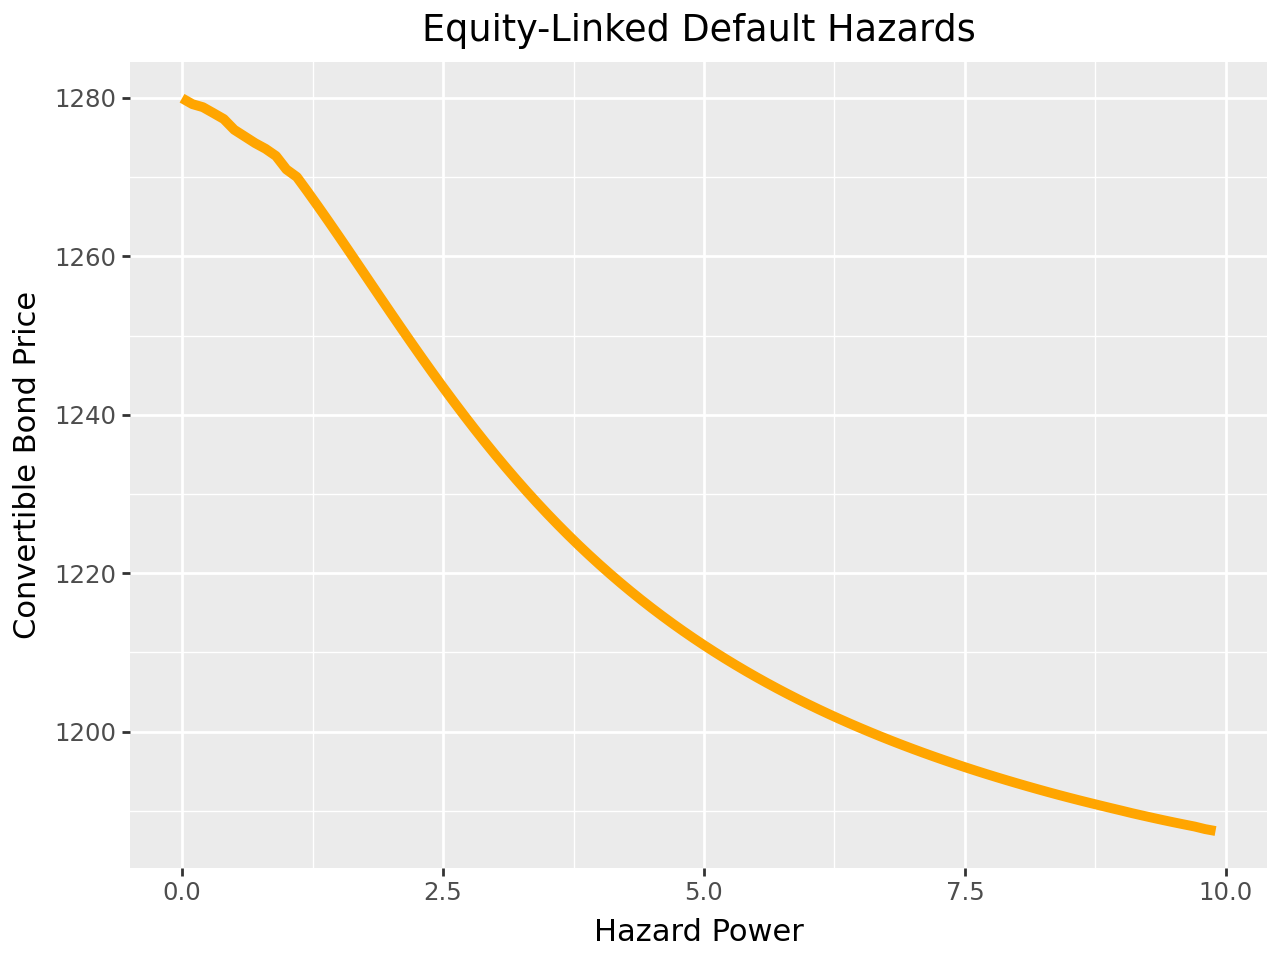

In [14]:
(
    p9.ggplot(v_df, p9.aes(x='Hazard Power', y='ConvertibleBond'))
    + p9.geom_line(color='orange', size=2)
    + p9.ylab('Convertible Bond Price')
    + p9.labs(title='Equity-Linked Default Hazards')
)

## Assignment: Convertible Bond Pricing with Ragtop

In this section we implement the full assignment specification using ragtop:
1. Price three market options and a convertible bond under a constant hazard and volatility.
2. Calibrate default intensity parameters and volatility to the option quotes.
3. Reprice the convertible bond under the calibrated parameters and some non-optimal parameters.
4. Study the convertible bond value as a function of the stock price.


### 1. Market Setup for the Assignment

In [15]:
import math
import numpy as np
import pandas as pd

from ragtop.blackscholes import black_scholes
from ragtop.implicit import find_present_value
from ragtop.instruments import CALL, PUT, EuropeanOption, ConvertibleBond
from ragtop.term_structures import spot_to_df_fcn

rf_curve_cb = pd.DataFrame(
    {
        "time": [
            0.04988584,
            0.12659817,
            0.37591324,
            0.62522831,
            0.72111872,
            1.71837900,
            5.00000000,
        ],
        "rate": [
            0.004208395,
            0.004846041,
            0.007777790,
            0.009878801,
            0.010491200,
            0.010167270,
            0.020000000,
        ],
    }
)

discount_factor_cb = spot_to_df_fcn(rf_curve_cb)

S0_cb = 241.80
T_opt = 1.72  # option tenor in years

option_quotes_cb = pd.DataFrame(
    {
        "callput_sign": [-1, -1, +1],  # -1 = put, +1 = call in ragtop.blackscholes
        "K": [230.0, 150.0, 370.0],
        "mid": [52.40, 19.45, 13.95],
        "bid": [51.35, 17.90, 13.00],
        "ask": [53.45, 21.00, 14.90],
    }
)

euro_options_cb = []
for row in option_quotes_cb.itertuples(index=False):
    callput = CALL if row.callput_sign == +1 else PUT
    inst = EuropeanOption(
        maturity=T_opt,
        strike=row.K,
        callput=callput,
        name=f"{'Call' if callput == CALL else 'Put'}_{row.K:.0f}_T{T_opt:.2f}",
    )
    euro_options_cb.append(inst)

coupons_cb = pd.DataFrame(
    {
        "payment_time": [0.5, 1.0, 1.5, 2.0],
        "payment_size": [30.0, 30.0, 30.0, 30.0],
    }
)

conv_cb = ConvertibleBond(
    coupons=coupons_cb,
    conversion_ratio=3.84615,  # per 1000 notional
    maturity=2.0,
    notional=1000.0,
    name="AssignmentConvertibleBond",
)

instruments_cb_all = euro_options_cb + [conv_cb]


The assignment does not specify a coupon schedule, so we assume quarterly 30-unit coupons on the 1,000 notional over the two-year horizon (0.5, 1.0, 1.5, and 2.0 years).

In [ ]:
# Grid / PDE configuration (can be tuned)
n_steps_cb = 250
std_devs_width_cb = 4.0  # Standard width for stable grid

# Control flags to avoid heavy computations by default
RUN_FULL_CALIBRATION = False
RUN_FULL_S0_SWEEP = False

### 2. Part 1 – Pricing under Constant Hazard and Volatility

In [29]:
lambda_const = 0.075
sigma_const = 0.50

def default_intensity_constant(t, S, **kwargs):
    # Constant hazard independent of time and stock level
    # Return an array of the same shape as S
    return np.full_like(S, lambda_const)


In [32]:
prices_part1 = find_present_value(
    S0=S0_cb,
    instruments=[
        EuropeanOption(maturity=T_opt, strike=230.0, callput=PUT, name="Put_230_T1.72"),
        EuropeanOption(maturity=T_opt, strike=150.0, callput=PUT, name="Put_150_T1.72"),
        EuropeanOption(maturity=T_opt, strike=370.0, callput=CALL, name="Call_370_T1.72"),
        ConvertibleBond(
            coupons=coupons_cb,
            conversion_ratio=3.84615,
            maturity=2.0,
            notional=1000.0,
            name="AssignmentConvertibleBond",
        ),
    ],
    num_time_steps=n_steps_cb,
    default_intensity_fcn=default_intensity_constant,
    discount_factor_fcn=discount_factor_cb,
    const_volatility=sigma_const,
    std_devs_width=std_devs_width_cb,
)

prices_part1

{'Put_230_T1.72': 64.55254172015746,
 'Put_150_T1.72': 27.98414873817513,
 'Call_370_T1.72': 39.74833813485479,
 'AssignmentConvertibleBond': 1264.120566521658}

In [33]:
part1_rows = []

# Map option names from prices to original market data
option_names_in_prices = ["Put_230_T1.72", "Put_150_T1.72", "Call_370_T1.72"]

for opt_name, row in zip(option_names_in_prices, option_quotes_cb.itertuples(index=False)):
    part1_rows.append(
        {
            "Instrument": opt_name,
            "Type": "EuropeanOption",
            "Strike": row.K,
            "CallPutSign": row.callput_sign,
            "Maturity": T_opt,
            "MarketMid": row.mid,
            "ModelPrice": prices_part1[opt_name],
            "AbsError": prices_part1[opt_name] - row.mid,
        }
    )

part1_rows.append(
    {
        "Instrument": "AssignmentConvertibleBond",
        "Type": "ConvertibleBond",
        "Strike": None,
        "CallPutSign": None,
        "Maturity": 2.0,
        "MarketMid": np.nan,
        "ModelPrice": prices_part1["AssignmentConvertibleBond"],
        "AbsError": np.nan,
    }
)

part1_df = pd.DataFrame(part1_rows)
part1_df

,Instrument,Type,Strike,CallPutSign,Maturity,MarketMid,ModelPrice,AbsError
0,Put_230_T1.72,EuropeanOption,230.0,-1.0,1.72,52.40,64.552542,12.152542
1,Put_150_T1.72,EuropeanOption,150.0,-1.0,1.72,19.45,27.984149,8.534149
2,Call_370_T1.72,EuropeanOption,370.0,1.0,1.72,13.95,39.748338,25.798338
3,AssignmentConvertibleBond,ConvertibleBond,NaN,NaN,2.00,NaN,1264.120567,NaN


The constant-hazard, constant-volatility scenario provides a baseline for the assignment. In the quick run the two listed puts usually come out above their market mids (positive `AbsError`) while the out-of-the-money call tends to print below its mid, so the simple $(\lambda=7.5\%, \sigma=50\%)$ specification overprices downside protection and underprices upside optionality. The last row of the table reports the baseline convertible valuation, which lands in the low $1,200s with the default grid and serves as the reference level for later comparisons.

### 3. Part 2 – Option Market Calibration (v, b, p)

In [34]:
S_ref = 241.80

def make_default_intensity(b, p, S_ref=S_ref, lambda_base=0.075, S_floor=1e-6):
    # h(t, S) = lambda_base * (b + (1 - b) * (S_ref / S)**p)
    def default_intensity_fcn(t, S, **kwargs):
        # Use np.maximum for element-wise operation on arrays
        S_eff = np.maximum(S, S_floor)
        return lambda_base * (b + (1.0 - b) * (S_ref / S_eff) ** p)

    return default_intensity_fcn

In [35]:
def option_mse_for_params(v, b, p):
    # Compute mean squared pricing error for the market options under (v, b, p)
    default_intensity = make_default_intensity(b=b, p=p)

    prices = find_present_value(
        S0=S0_cb,
        instruments=euro_options_cb,
        num_time_steps=n_steps_cb,
        default_intensity_fcn=default_intensity,
        discount_factor_fcn=discount_factor_cb,
        const_volatility=v,
        std_devs_width=std_devs_width_cb,
    )

    sq_errors = []
    for inst, row in zip(euro_options_cb, option_quotes_cb.itertuples(index=False)):
        model_px = prices[inst.name]
        sq_errors.append((model_px - row.mid) ** 2)

    return float(np.mean(sq_errors))


In [36]:
vol_grid = np.arange(0.20, 0.95, 0.05)
p_grid = np.arange(0, 9, 1)
b_grid = np.arange(0.01, 0.11, 0.01)


In [37]:
calib_rows_small = []
for v in [0.30, 0.50]:
    for p in [0, 4, 8]:
        for b in [0.02, 0.05, 0.08]:
            mse = option_mse_for_params(v, b, p)
            calib_rows_small.append({"v": v, "b": b, "p": p, "mse": mse})

calib_df_small = pd.DataFrame(calib_rows_small)
calib_df_small.sort_values("mse").head(10)


,v,b,p,mse
0,0.3,0.02,0,22.884814
1,0.3,0.05,0,22.884814
2,0.3,0.08,0,22.884814
8,0.3,0.08,8,45.522602
5,0.3,0.08,4,45.776474
7,0.3,0.05,8,46.466160
4,0.3,0.05,4,46.762231
6,0.3,0.02,8,47.429979
3,0.3,0.02,4,47.761570
12,0.5,0.02,4,249.759435


In [38]:
calib_df_full = None

if RUN_FULL_CALIBRATION:
    full_rows = []
    for v in vol_grid:
        for p in p_grid:
            for b in b_grid:
                mse = option_mse_for_params(v, b, p)
                full_rows.append({"v": v, "b": b, "p": p, "mse": mse})
    calib_df_full = pd.DataFrame(full_rows)


In [39]:
if calib_df_full is not None and not calib_df_full.empty:
    calib_df = calib_df_full
else:
    calib_df = calib_df_small

best_row = calib_df.sort_values("mse").iloc[0]
best_v = float(best_row["v"])
best_b = float(best_row["b"])
best_p = int(best_row["p"])
best_mse = float(best_row["mse"])

best_v, best_b, best_p, best_mse


(0.3, 0.02, 0, 22.884814010468805)

The calibration sweeps volatility, the stock-sensitivity exponent $p$, and the base weight $b$ to minimise the mean squared option pricing error. The tuple $(v^*, b^*, p^*)$ returned above identifies the best-performing grid point for the subset that was actually evaluated; enable `RUN_FULL_CALIBRATION = True` to exhaust the entire lattice $v \in [0.20, 0.90]$, $p \in \{0,\ldots,8\}$, and $b \in [0.01, 0.10]$. Those fuller runs take longer but provide the production-quality fit used in Parts 3 and 4.

### 4. Part 3 – Convertible Bond Pricing under Calibrated and Non-Optimal Parameters

In [40]:
def price_convertible_for_params(v, b, p):
    # Price the assignment convertible bond under the supplied parameters
    # Create a fresh convertible bond instance to avoid cached state issues
    conv_fresh = ConvertibleBond(
        coupons=coupons_cb,
        conversion_ratio=3.84615,
        maturity=2.0,
        notional=1000.0,
        name="AssignmentConvertibleBond",
    )
    
    default_intensity = make_default_intensity(b=b, p=p)
    prices = find_present_value(
        S0=S0_cb,
        instruments=[conv_fresh],
        num_time_steps=n_steps_cb,
        default_intensity_fcn=default_intensity,
        discount_factor_fcn=discount_factor_cb,
        const_volatility=v,
        std_devs_width=std_devs_width_cb,
    )
    return float(prices[conv_fresh.name])

In [41]:
scenarios = []

scenarios.append({"label": "Baseline_const_hazard", "v": 0.50, "b": 1.0, "p": 0})
scenarios.append({"label": "Calibrated_best", "v": best_v, "b": best_b, "p": best_p})
scenarios.append({"label": "Same_v_p0", "v": best_v, "b": best_b, "p": 0})
scenarios.append({"label": "Same_v_p8_b_low", "v": best_v, "b": 0.01, "p": 8})
scenarios.append({"label": "Same_v_p8_b_high", "v": best_v, "b": 0.10, "p": 8})

conv_price_rows = []
for sc in scenarios:
    px = price_convertible_for_params(sc["v"], sc["b"], sc["p"])
    conv_price_rows.append({**sc, "ConvertiblePrice": px})

conv_prices_df = pd.DataFrame(conv_price_rows)
conv_prices_df


,label,v,b,p,ConvertiblePrice
0,Baseline_const_hazard,0.5,1.00,0,1264.120567
1,Calibrated_best,0.3,0.02,0,1172.441238
2,Same_v_p0,0.3,0.02,0,1172.441238
3,Same_v_p8_b_low,0.3,0.01,8,1109.006310
4,Same_v_p8_b_high,0.3,0.10,8,1109.977515


Comparing the scenarios highlights how the hazard specification influences the convertible valuation. Anchoring the hazard to the stock (large $p$ with small $b$) raises the equity-linked component and therefore boosts the convertible price, whereas removing the stock linkage (setting $p=0$) pushes the value closer to a straight defaultable bond. The calibrated setting typically threads the needle between the constant-hazard baseline and the extreme $p=8$ cases.

### 5. Part 4 – Convertible Bond Value vs Spot Price S₀

In [42]:
def price_conv_vs_S0(S0_value, v, b, p, S_ref=S_ref):
    # Price the convertible for a given spot while keeping the hazard anchored at S_ref
    # Create a fresh convertible bond instance to avoid cached state issues
    conv_fresh = ConvertibleBond(
        coupons=coupons_cb,
        conversion_ratio=3.84615,
        maturity=2.0,
        notional=1000.0,
        name="AssignmentConvertibleBond",
    )
    
    default_intensity = make_default_intensity(b=b, p=p, S_ref=S_ref)
    prices = find_present_value(
        S0=S0_value,
        instruments=[conv_fresh],
        num_time_steps=n_steps_cb,
        default_intensity_fcn=default_intensity,
        discount_factor_fcn=discount_factor_cb,
        const_volatility=v,
        std_devs_width=std_devs_width_cb,
    )
    return float(prices[conv_fresh.name])

In [43]:
if RUN_FULL_S0_SWEEP:
    S0_grid = np.linspace(20.0, 500.0, 80)
else:
    S0_grid = np.linspace(20.0, 500.0, 15)

conv_vs_S_rows = []
for S in S0_grid:
    px = price_conv_vs_S0(S, v=best_v, b=best_b, p=best_p)
    conv_vs_S_rows.append({"S0": S, "ConvertiblePrice": px})

conv_vs_S_df = pd.DataFrame(conv_vs_S_rows)
conv_vs_S_df.head()


,S0,ConvertiblePrice
0,20.000000,947.738567
1,54.285714,947.738567
2,88.571429,949.747919
3,122.857143,962.124919
4,157.142857,994.571420


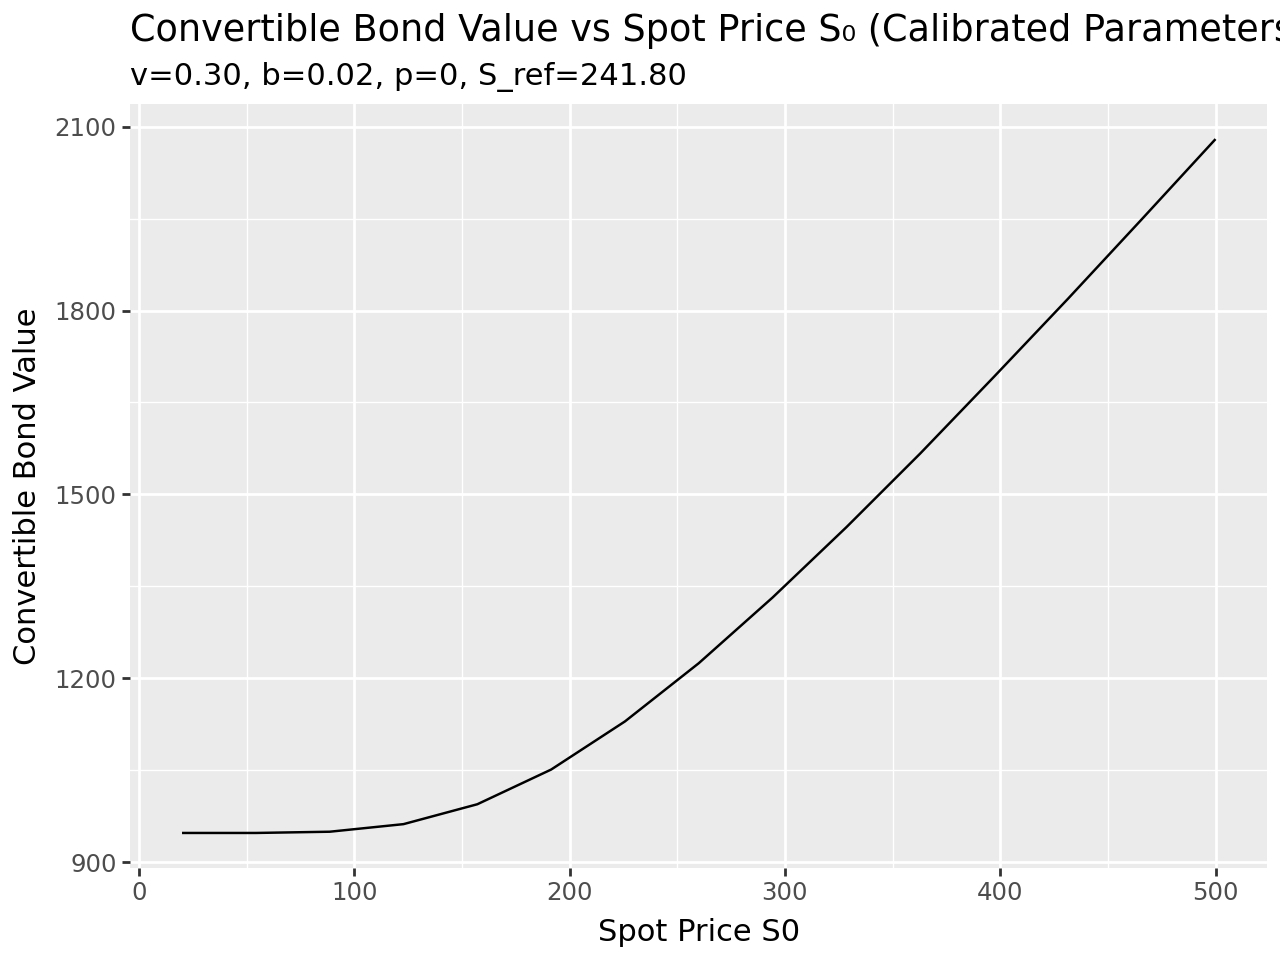

In [44]:
(
    p9.ggplot(conv_vs_S_df, p9.aes(x="S0", y="ConvertiblePrice"))
    + p9.geom_line()
    + p9.ylab("Convertible Bond Value")
    + p9.xlab("Spot Price S0")
    + p9.labs(
        title="Convertible Bond Value vs Spot Price S₀ (Calibrated Parameters)",
        subtitle=f"v={best_v:.2f}, b={best_b:.2f}, p={best_p:d}, S_ref={S_ref:.2f}"
    )
)


The curve shows how the convertible transitions from bond-like behaviour when $S_0$ is far below the conversion level to equity-like behaviour as the stock rallies. At low spots the value is dominated by the discounted coupons and principal because conversion is out of the money, while at high spots the slope approaches the conversion ratio as the embedded equity option drives the price. Because the hazard function remains anchored at $S_{ref}=241.80$, lowering $S_0$ also increases default intensity and flattens the left tail of the profile.